This package implements the basic machinery for decorrelated backpropagation.

In [23]:
import numpy as np
import torch
from src.decorrelation import covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by showing effective decorrelation of correlated input

iteration 0; average off-diagonal covariance: 0.189962
iteration 1; average off-diagonal covariance: 0.188300
iteration 2; average off-diagonal covariance: 0.186666
iteration 3; average off-diagonal covariance: 0.185058
iteration 4; average off-diagonal covariance: 0.183475
iteration 5; average off-diagonal covariance: 0.181917
iteration 6; average off-diagonal covariance: 0.180383
iteration 7; average off-diagonal covariance: 0.178873
iteration 8; average off-diagonal covariance: 0.177387
iteration 9; average off-diagonal covariance: 0.175923
iteration 10; average off-diagonal covariance: 0.174481
iteration 11; average off-diagonal covariance: 0.173061
iteration 12; average off-diagonal covariance: 0.171662
iteration 13; average off-diagonal covariance: 0.170284
iteration 14; average off-diagonal covariance: 0.168926
iteration 15; average off-diagonal covariance: 0.167588
iteration 16; average off-diagonal covariance: 0.166269
iteration 17; average off-diagonal covariance: 0.164969
it

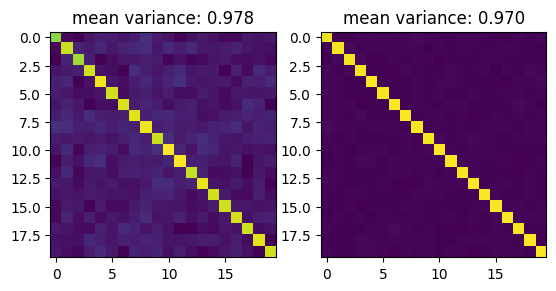

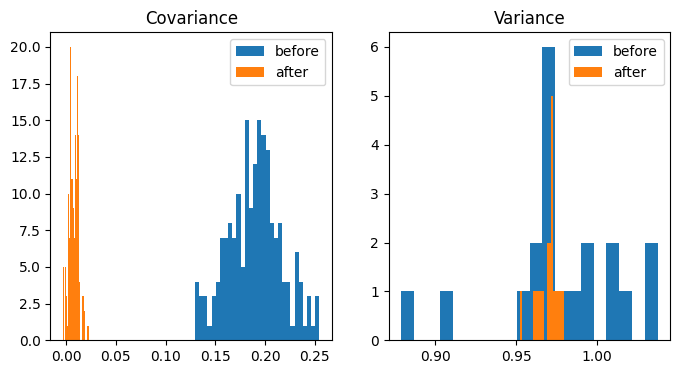

In [24]:
num_samples=1000
num_features=20

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a fully connected decorrelator
model = DecorrelationFC(num_features, whiten=True) # NOTE: the whitening constraint is only realised weakly due to the off-diagonal constraints; we observe a weak tendency to unit variance

# covariance matrix before training
A1 = model.covariance(model.forward(data))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-3 * model.R.grad
    print(f'iteration {i}; average off-diagonal covariance: {covariance([model])[0].numpy():3f}')

# covariance matrix after training
A2 = model.covariance(model.forward(data))

plt.subplot(1,2,1)
plt.imshow(A1)
plt.title(f'mean variance: {torch.mean(torch.diag(A1)):.3f}')
plt.subplot(1,2,2)
plt.imshow(A2)
plt.title(f'mean variance: {torch.mean(torch.diag(A2)):.3f}');

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(lower_triangular(A1), bins=30)
plt.hist(lower_triangular(A2), bins=30)
plt.title('Covariance')
plt.legend(['before', 'after'])
plt.subplot(1,2,2)
plt.hist(torch.diag(A1), bins=A1.shape[0])
plt.hist(torch.diag(A2), bins=A2.shape[0])
plt.title('Variance')
plt.legend(['before', 'after']);



Decorrelation of correlated input represented in convolutional [N, C, H, W] form

iteration 0; average off-diagonal kernel covariance: 0.738838
iteration 1; average off-diagonal kernel covariance: 0.302167
iteration 2; average off-diagonal kernel covariance: 0.222693
iteration 3; average off-diagonal kernel covariance: 0.179713
iteration 4; average off-diagonal kernel covariance: 0.152071
iteration 5; average off-diagonal kernel covariance: 0.132587
iteration 6; average off-diagonal kernel covariance: 0.118032
iteration 7; average off-diagonal kernel covariance: 0.106706
iteration 8; average off-diagonal kernel covariance: 0.097623
iteration 9; average off-diagonal kernel covariance: 0.090166
iteration 10; average off-diagonal kernel covariance: 0.083928
iteration 11; average off-diagonal kernel covariance: 0.078628
iteration 12; average off-diagonal kernel covariance: 0.074069
iteration 13; average off-diagonal kernel covariance: 0.070103
iteration 14; average off-diagonal kernel covariance: 0.066620
iteration 15; average off-diagonal kernel covariance: 0.063538
it

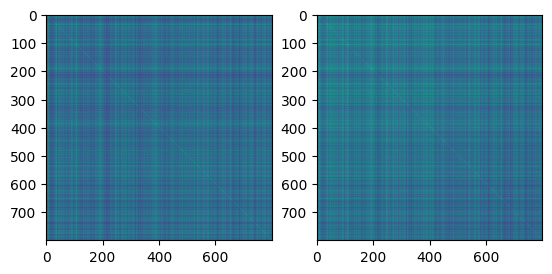

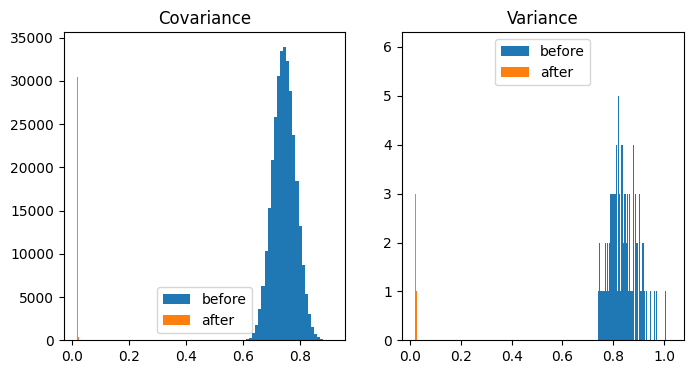

In [25]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(5,5)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,num_channels,height,width)

# create a convolutional decorrelator
model = DecorrelationPatch2d(2, kernel_size=kernel_size, whiten=True)

# correlation matrix before training
B1 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-2 * model.R.grad
    print(f'iteration {i}; average off-diagonal kernel covariance: {covariance([model])[0].numpy():3f}')

# correlation matrix after training
B2 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

plt.subplot(1,2,1)
plt.imshow(B1)
plt.subplot(1,2,2)
plt.imshow(B2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(lower_triangular(B1), bins=30)
plt.hist(lower_triangular(B2), bins=30)
plt.title('Covariance')
plt.legend(['before', 'after'])
plt.subplot(1,2,2)
plt.hist(torch.diag(B1), bins=B1.shape[0])
plt.hist(torch.diag(B2), bins=B2.shape[0])
plt.title('Variance')
plt.legend(['before', 'after']);

# NOTE: It is likely not the covariance but the correlations we wish to show...

In [26]:
# MAYBE IT ALREADY WORKS? INPUT DATA SHOULD BE TRANSLATION INVARIANT? THIS IS DEFINITELY NOT THE CASE IN GENERAL... NEEDS MORE THOUGHT

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison